# Question 4: Fight features analysis

We want to explore patterns in UFC fight characteristics. Namely we want to understand how fights end in different rounds, with different outcomes and the geographical distribution of venues. By doing this we want to understand the physical aspects of fights and the business strategies behind organizing events. This analysis will reveal trends influencing fight outcomes and provide insights into the sport's competitive dynamics.


In [1]:
from scipy.ndimage import gaussian_filter1d

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


In [2]:
base_folder_path = "datasets/"
stats = pd.read_csv(base_folder_path + "stats.csv", delimiter=";")

print(stats.head())


   red_fighter_name blue_fighter_name  event_date red_fighter_nickname  \
0      ILIA TOPURIA      MAX HOLLOWAY  26/10/2024           El Matador   
1  ROBERT WHITTAKER   KHAMZAT CHIMAEV  26/10/2024           The Reaper   
2  MAGOMED ANKALAEV  ALEKSANDAR RAKIC  26/10/2024                    -   
3     LERONE MURPHY           DAN IGE  26/10/2024          The Miracle   
4   SHARA MAGOMEDOV   ARMEN PETROSYAN  26/10/2024               Bullet   

  blue_fighter_nickname red_fighter_result blue_fighter_result  \
0               Blessed                  W                   L   
1                  Borz                  L                   W   
2                Rocket                  W                   L   
3                   50K                  W                   L   
4              Superman                  W                   L   

                 method  round  time  ... red_fighter_sig_str_body_pct  \
0                KO/TKO      3  1:34  ...                           14   
1         

## Distribution of fight locations


Number of unique countries: 28


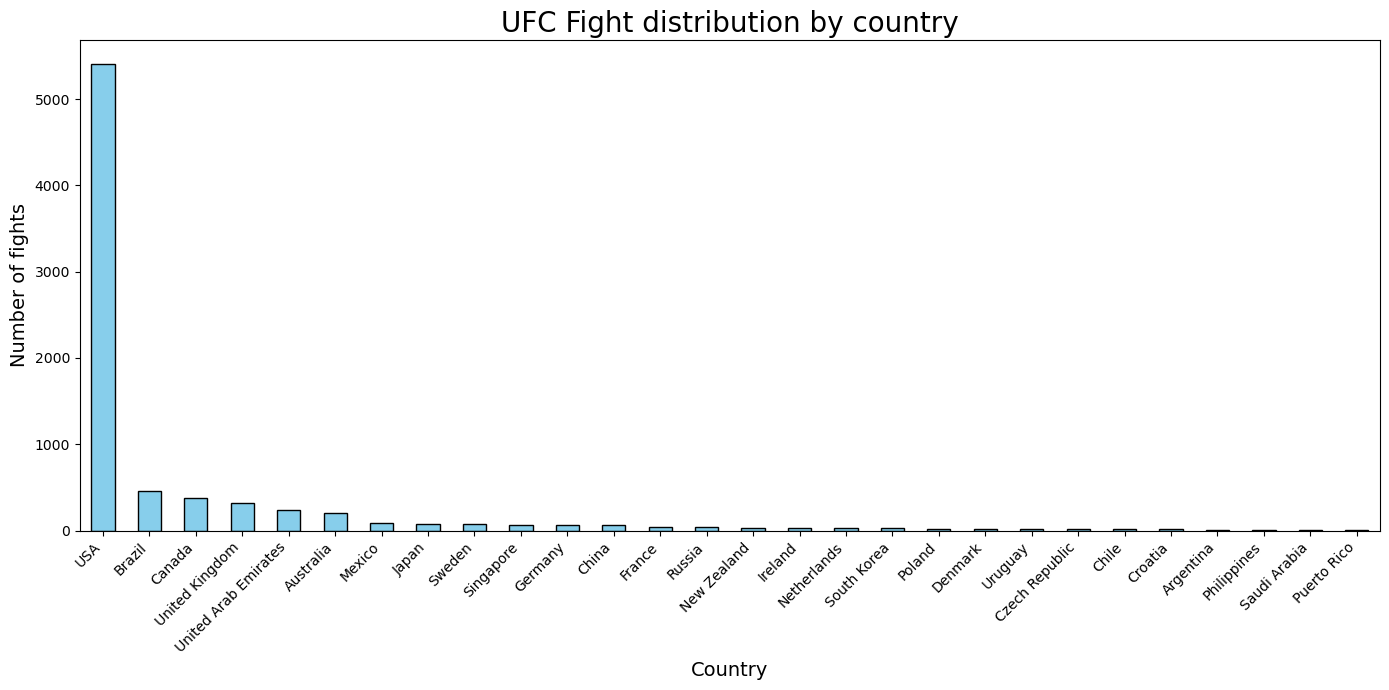

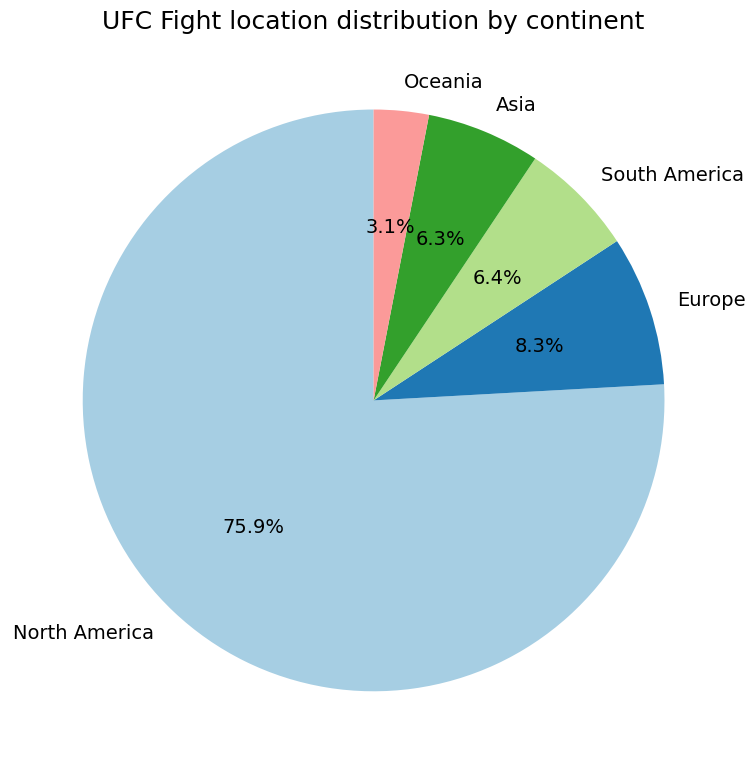

In [3]:
# Fights by country
stats["country"] = stats["event_location"].str.extract(r",\s*([^,]+)$")
stats["country"] = stats["country"].str.strip()
stats["country"] = stats["country"].fillna("Unknown")

unique_countries = stats["country"].unique()
print("Number of unique countries:", len(unique_countries))

country_counts = stats["country"].value_counts()


plt.figure(figsize=(14, 7))
country_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("UFC Fight distribution by country", fontsize=20)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number of fights", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

continent_mapping = {
    "United Arab Emirates": "Asia",
    "USA": "North America",
    "France": "Europe",
    "Australia": "Oceania",
    "United Kingdom": "Europe",
    "Saudi Arabia": "Asia",
    "Brazil": "South America",
    "Mexico": "North America",
    "Canada": "North America",
    "Singapore": "Asia",
    "New Zealand": "Oceania",
    "South Korea": "Asia",
    "Russia": "Europe",
    "Denmark": "Europe",
    "China": "Asia",
    "Uruguay": "South America",
    "Sweden": "Europe",
    "Czech Republic": "Europe",
    "Argentina": "South America",
    "Germany": "Europe",
    "Chile": "South America",
    "Poland": "Europe",
    "Japan": "Asia",
    "Netherlands": "Europe",
    "Croatia": "Europe",
    "Ireland": "Europe",
    "Philippines": "Asia",
    "Puerto Rico": "North America",
    "Unknown": "Unknown",
}

# Fights by continent
stats["continent"] = stats["country"].map(continent_mapping)

continent_counts = stats["continent"].value_counts()

plt.figure(figsize=(8, 8))
continent_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Paired.colors,
    textprops={"fontsize": 14},
)
plt.title("UFC Fight location distribution by continent", fontsize=18)
plt.ylabel("")
plt.tight_layout()
plt.show()


## Distribution of fight outcomes by country


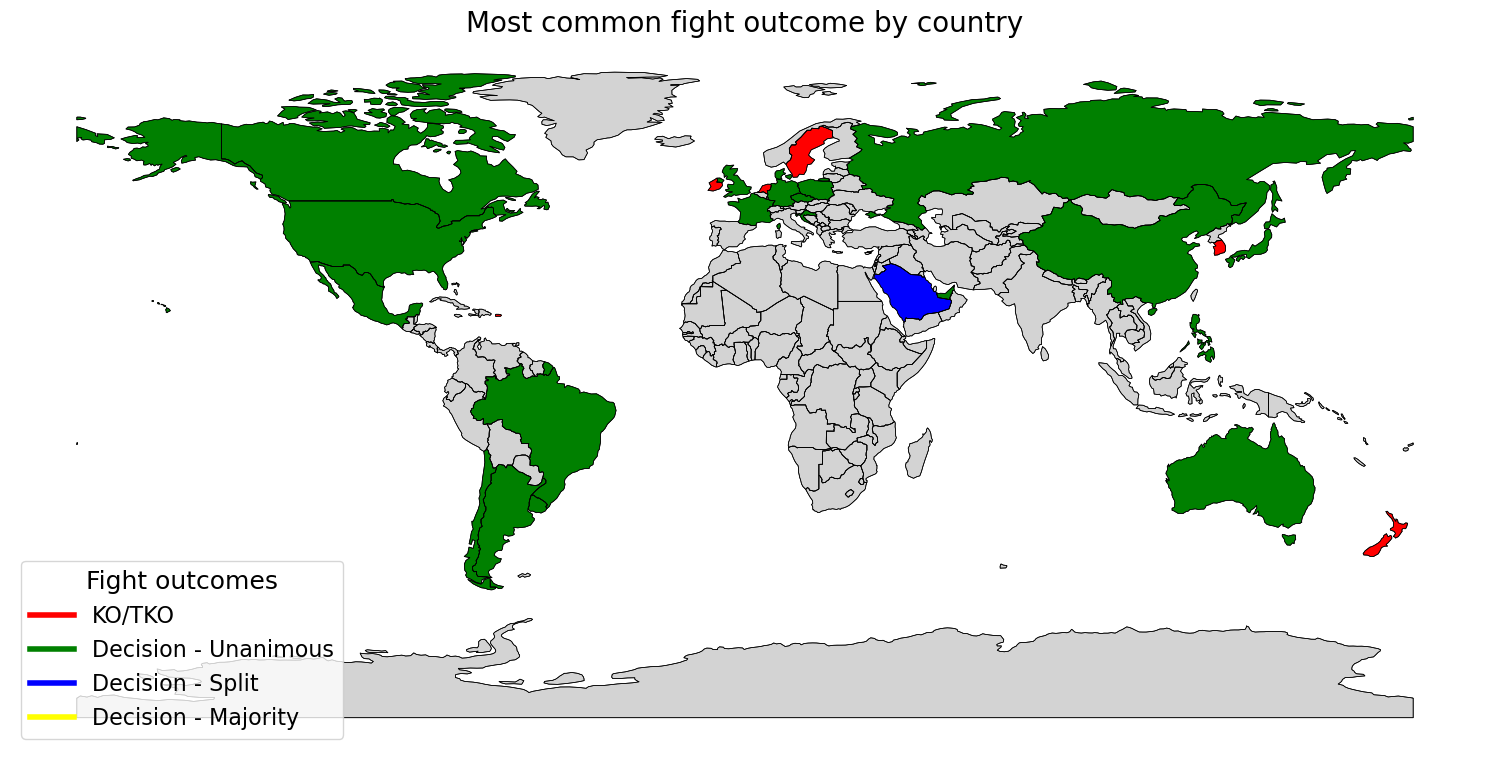


Decision - Split:
    Saudi Arabia - 27.27% of fights

Decision - Unanimous:
    Argentina - 41.67% of fights
    Australia - 36.76% of fights
    Brazil - 33.19% of fights
    Canada - 41.1% of fights
    Chile - 46.15% of fights
    China - 37.7% of fights
    Croatia - 46.15% of fights
    Czechia - 46.15% of fights
    Denmark - 46.15% of fights
    France - 43.24% of fights
    Germany - 46.97% of fights
    Japan - 36.71% of fights
    Mexico - 34.15% of fights
    Philippines - 33.33% of fights
    Poland - 60.87% of fights
    Russia - 47.22% of fights
    Singapore - 37.14% of fights
    United Arab Emirates - 45.49% of fights
    United Kingdom - 35.31% of fights
    United States of America - 35.24% of fights
    Uruguay - 38.46% of fights

KO/TKO:
    Ireland - 41.38% of fights
    Netherlands - 44.0% of fights
    New Zealand - 39.39% of fights
    Puerto Rico - 55.56% of fights
    South Korea - 37.5% of fights
    Sweden - 36.11% of fights


In [4]:
country_name_mapping = {
    "USA": "United States of America",
    "United Kingdom": "United Kingdom",
    "United Arab Emirates": "United Arab Emirates",
    "Czech Republic": "Czechia",
    "South Korea": "South Korea",
    "Puerto Rico": "Puerto Rico",
    "Netherlands": "Netherlands",
    "New Zealand": "New Zealand",
    "Sweden": "Sweden",
    "Ireland": "Ireland",
    "Uruguay": "Uruguay",
    "Saudi Arabia": "Saudi Arabia",
    "Argentina": "Argentina",
    "Australia": "Australia",
    "Brazil": "Brazil",
    "Canada": "Canada",
    "Chile": "Chile",
    "China": "China",
    "Croatia": "Croatia",
    "Denmark": "Denmark",
    "France": "France",
    "Germany": "Germany",
    "Japan": "Japan",
    "Mexico": "Mexico",
    "Philippines": "Philippines",
    "Poland": "Poland",
    "Russia": "Russia",
    "Singapore": "Singapore",
}  # Map country names to their official names in the shapefiles


country_outcomes = stats.groupby(["country", "method"]).size().reset_index(name="count")
prominent_outcomes_country = country_outcomes.loc[
    country_outcomes.groupby("country")["count"].idxmax()
]
total_fights_by_country = (
    stats.groupby("country").size().reset_index(name="total_fights")
)
prominent_outcomes_country = prominent_outcomes_country.merge(
    total_fights_by_country, on="country"
)
prominent_outcomes_country["country"] = prominent_outcomes_country["country"].replace(
    country_name_mapping
)
prominent_outcomes_country["percentage"] = (
    (prominent_outcomes_country["count"] / prominent_outcomes_country["total_fights"])
    * 100
).round(2)
world = gpd.read_file("shapefiles/ne_110m_admin_0_countries.shp")
world = world.merge(
    prominent_outcomes_country, how="left", left_on="NAME", right_on="country"
)
outcome_colors = {
    "KO/TKO": "red",
    "Decision - Unanimous": "green",
    "Decision - Split": "blue",
    "Decision - Majority": "yellow",
}

world["color"] = world["method"].map(outcome_colors).fillna("lightgray")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black")
world.plot(ax=ax, color=world["color"], edgecolor="black", linewidth=0.5)
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in outcome_colors.values()]
labels = list(outcome_colors.keys())
plt.legend(
    handles,
    labels,
    title="Fight outcomes",
    loc="lower left",
    fontsize=16,
    title_fontsize=18,
)
plt.title("Most common fight outcome by country", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.show()

grouped_outcomes = prominent_outcomes_country.sort_values(
    by=["method", "country"], ascending=[True, True]
)

current_method = None
for idx, row in grouped_outcomes.iterrows():
    if row["method"] != current_method:
        current_method = row["method"]
        print(f"\n{current_method}:")
    print(f"    {row['country']} - {row['percentage']}% of fights")


## Distribution of fights by rounds across countries


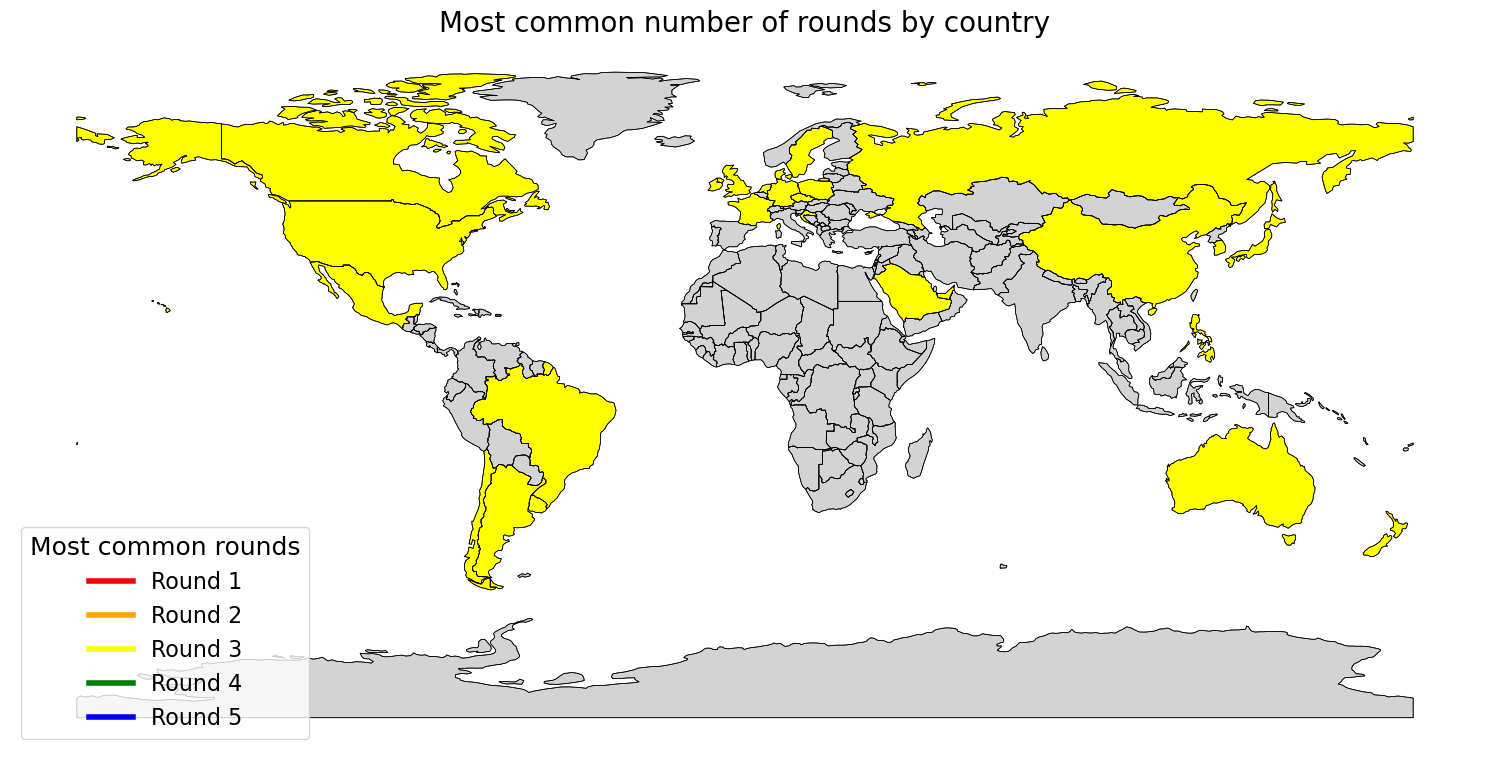


Round 1:
    Puerto Rico - 100.0% of fights

Round 3:
    Argentina - 50.0% of fights
    Australia - 52.45% of fights
    Brazil - 48.47% of fights
    Canada - 57.33% of fights
    Chile - 53.85% of fights
    China - 63.93% of fights
    Croatia - 46.15% of fights
    Czechia - 53.85% of fights
    Denmark - 61.54% of fights
    France - 62.16% of fights
    Germany - 63.64% of fights
    Ireland - 48.28% of fights
    Japan - 50.63% of fights
    Mexico - 56.1% of fights
    Netherlands - 52.0% of fights
    New Zealand - 45.45% of fights
    Philippines - 50.0% of fights
    Poland - 69.57% of fights
    Russia - 63.89% of fights
    Saudi Arabia - 81.82% of fights
    Singapore - 51.43% of fights
    South Korea - 58.33% of fights
    Sweden - 47.22% of fights
    United Arab Emirates - 57.08% of fights
    United Kingdom - 50.0% of fights
    United States of America - 49.38% of fights
    Uruguay - 53.85% of fights


In [5]:
round_distribution = (
    stats.groupby(["country", "round"]).size().reset_index(name="count")
)
most_common_rounds = round_distribution.loc[
    round_distribution.groupby("country")["count"].idxmax()
]
total_fights_by_country = (
    stats.groupby("country").size().reset_index(name="total_fights")
)
most_common_rounds = most_common_rounds.merge(
    total_fights_by_country, on="country"
).assign(percentage=lambda df: ((df["count"] / df["total_fights"]) * 100).round(2))
most_common_rounds["country"] = most_common_rounds["country"].replace(
    country_name_mapping
)
world = gpd.read_file("shapefiles/ne_110m_admin_0_countries.shp")
world = world.merge(most_common_rounds, how="left", left_on="NAME", right_on="country")
round_colors = {
    1: "red",
    2: "orange",
    3: "yellow",
    4: "green",
    5: "blue",
}
world["color"] = world["round"].map(round_colors).fillna("lightgray")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black")
world.plot(ax=ax, color=world["color"], edgecolor="black", linewidth=0.5)
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in round_colors.values()]
labels = [f"Round {round_num}" for round_num in round_colors.keys()]
plt.legend(
    handles,
    labels,
    title="Most common rounds",
    loc="lower left",
    fontsize=16,
    title_fontsize=18,
)
plt.title("Most common number of rounds by country", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.show()

grouped_rounds = most_common_rounds.sort_values(
    by=["round", "country"], ascending=[True, True]
)

current_round = None
for idx, row in grouped_rounds.iterrows():
    if row["round"] != current_round:
        current_round = row["round"]
        print(f"\nRound {current_round}:")
    print(f"    {row['country']} - {row['percentage']}% of fights")


## Most common round to have fight stoppage by countries


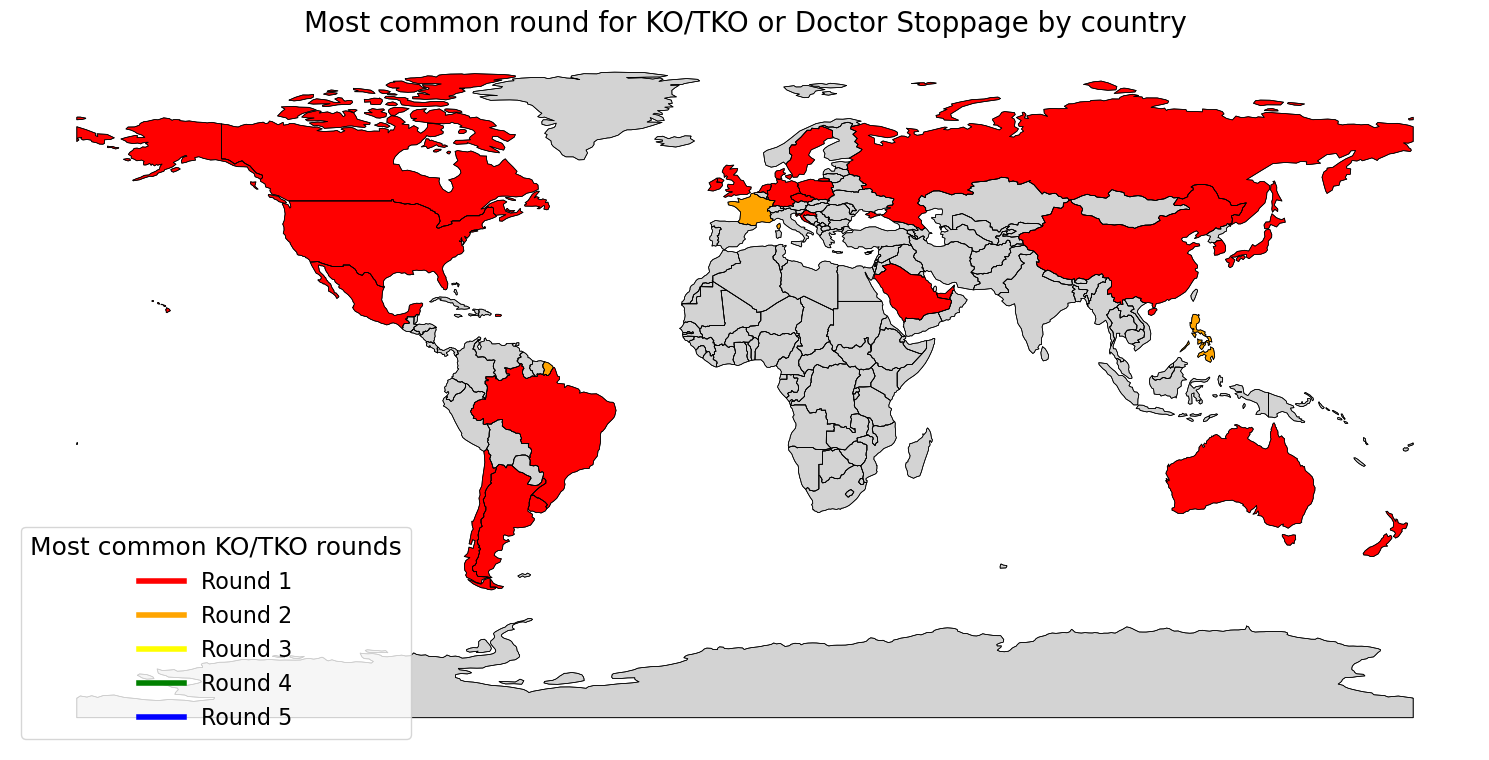


Round 1:
    Argentina - 33.33% of fights
    Australia - 54.29% of fights
    Brazil - 52.6% of fights
    Canada - 55.36% of fights
    Chile - 100.0% of fights
    China - 76.47% of fights
    Croatia - 80.0% of fights
    Czechia - 50.0% of fights
    Denmark - 75.0% of fights
    Germany - 50.0% of fights
    Ireland - 58.33% of fights
    Japan - 48.0% of fights
    Mexico - 57.89% of fights
    Netherlands - 36.36% of fights
    New Zealand - 69.23% of fights
    Poland - 33.33% of fights
    Puerto Rico - 100.0% of fights
    Russia - 55.56% of fights
    Saudi Arabia - 66.67% of fights
    Singapore - 54.55% of fights
    South Korea - 66.67% of fights
    Sweden - 69.23% of fights
    United Arab Emirates - 53.03% of fights
    United Kingdom - 55.24% of fights
    United States of America - 53.18% of fights
    Uruguay - 50.0% of fights

Round 2:
    France - 46.15% of fights
    Philippines - 66.67% of fights


In [6]:
ko_tko_distribution = (
    stats[stats["method"].isin(["KO/TKO", "TKO - Doctor's Stoppage"])]
    .groupby(["country", "round"])
    .size()
    .reset_index(name="count")
)
most_common_ko_tko_rounds = ko_tko_distribution.loc[
    ko_tko_distribution.groupby("country")["count"].idxmax()
]
total_ko_tko_fights_by_country = (
    stats[stats["method"].isin(["KO/TKO", "TKO - Doctor's Stoppage"])]
    .groupby("country")
    .size()
    .reset_index(name="total_fights")
)
most_common_ko_tko_rounds = most_common_ko_tko_rounds.merge(
    total_ko_tko_fights_by_country, on="country"
).assign(percentage=lambda df: ((df["count"] / df["total_fights"]) * 100).round(2))
most_common_ko_tko_rounds["country"] = most_common_ko_tko_rounds["country"].replace(
    country_name_mapping
)
world = gpd.read_file("shapefiles/ne_110m_admin_0_countries.shp")
world = world.merge(
    most_common_ko_tko_rounds, how="left", left_on="NAME", right_on="country"
)
world["color"] = world["round"].map(round_colors).fillna("lightgray")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black")
world.plot(ax=ax, color=world["color"], edgecolor="black", linewidth=0.5)
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in round_colors.values()]
labels = [f"Round {round_num}" for round_num in round_colors.keys()]
plt.legend(
    handles,
    labels,
    title="Most common KO/TKO rounds",
    loc="lower left",
    fontsize=16,
    title_fontsize=18,
)
plt.title("Most common round for KO/TKO or Doctor Stoppage by country", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.show()

grouped_ko_tko_rounds = most_common_ko_tko_rounds.sort_values(
    by=["round", "country"], ascending=[True, True]
)

current_round = None
for idx, row in grouped_ko_tko_rounds.iterrows():
    if row["round"] != current_round:
        current_round = row["round"]
        print(f"\nRound {current_round}:")
    print(f"    {row['country']} - {row['percentage']}% of fights")


## Distribution of fight stoppages by round by country


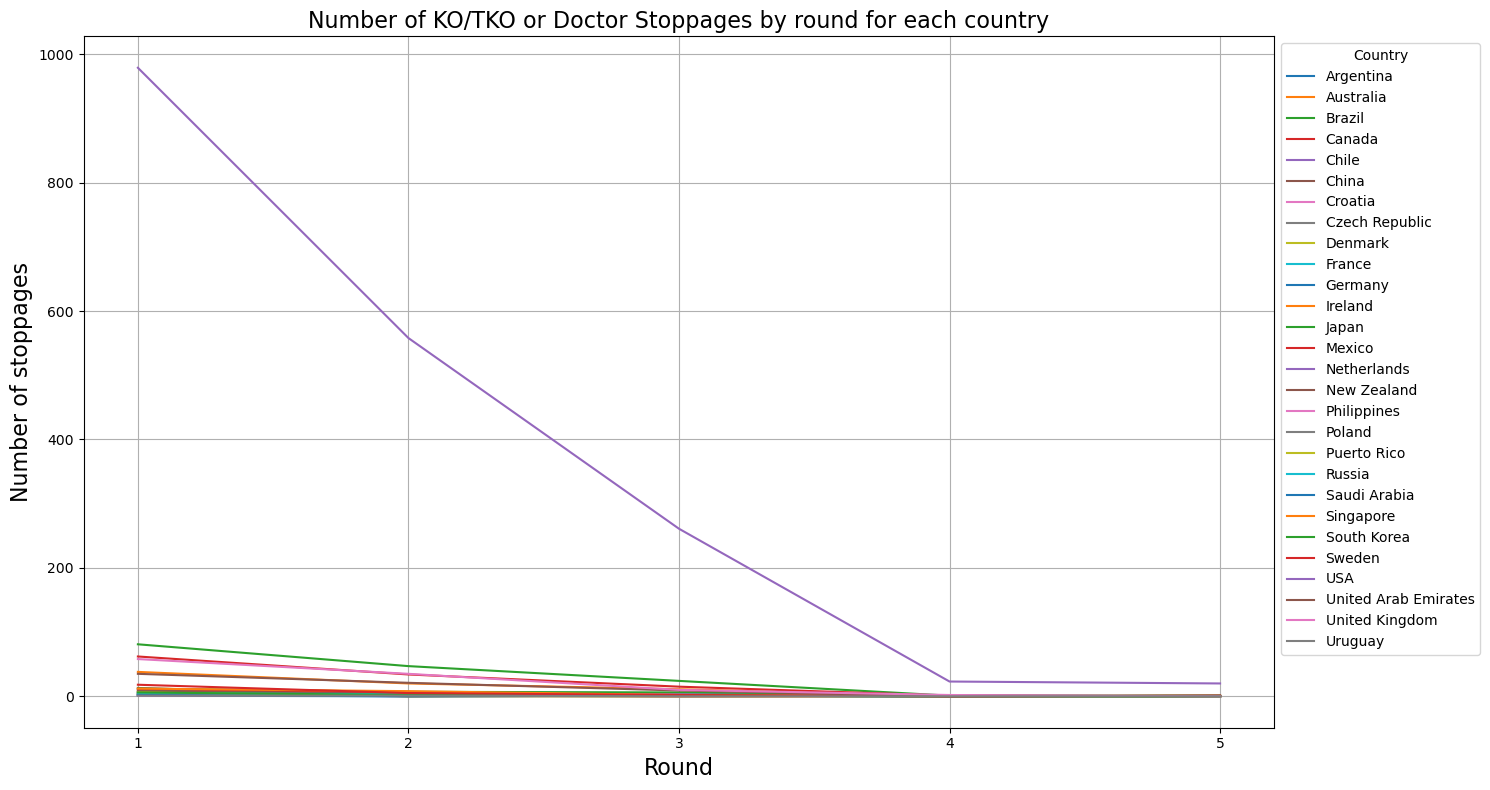

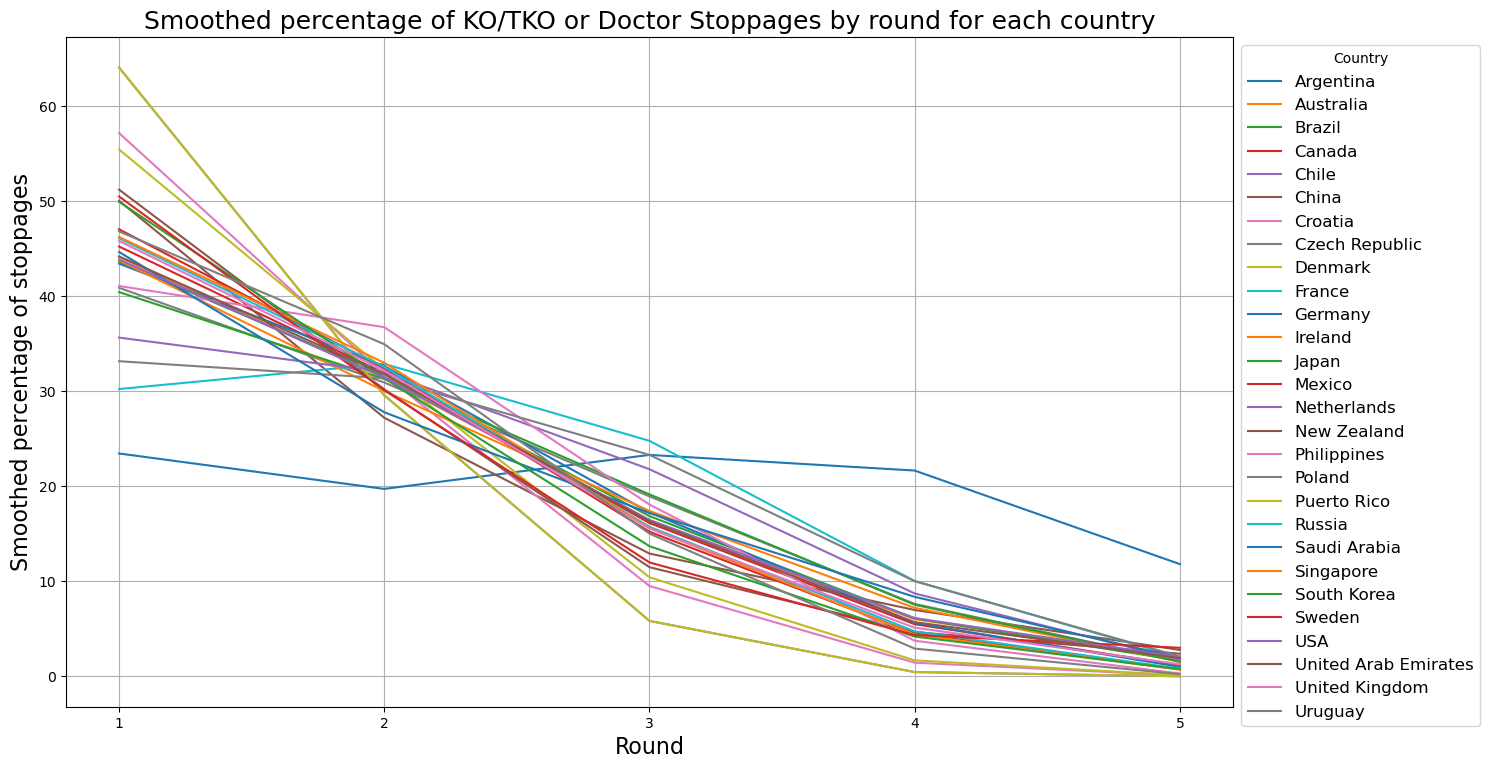

In [7]:
ko_tko_line_data = (
    stats[stats["method"].isin(["KO/TKO", "TKO - Doctor's Stoppage"])]
    .groupby(["country", "round"])
    .size()
    .reset_index(name="count")
)
ko_tko_pivot = ko_tko_line_data.pivot(
    index="round", columns="country", values="count"
).fillna(0)

plt.figure(figsize=(15, 8))
for country in ko_tko_pivot.columns:
    plt.plot(ko_tko_pivot.index, ko_tko_pivot[country], label=country)

plt.title("Number of KO/TKO or Doctor Stoppages by round for each country", fontsize=16)
plt.xlabel("Round", fontsize=16)
plt.ylabel("Number of stoppages", fontsize=16)
plt.xticks(range(1, 6))
plt.legend(title="Country", bbox_to_anchor=(1, 1), loc="upper left", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

normalized_ko_tko_data = (
    stats[stats["method"].isin(["KO/TKO", "TKO - Doctor's Stoppage"])]
    .groupby(["country", "round"])
    .size()
    .reset_index(name="count")
)
total_stoppages_by_country = (
    stats[stats["method"].isin(["KO/TKO", "TKO - Doctor's Stoppage"])]
    .groupby("country")
    .size()
    .reset_index(name="total_stoppages")
)
normalized_ko_tko_data = normalized_ko_tko_data.merge(
    total_stoppages_by_country, on="country"
).assign(percentage=lambda df: (df["count"] / df["total_stoppages"]) * 100)
normalized_ko_tko_pivot = normalized_ko_tko_data.pivot(
    index="round", columns="country", values="percentage"
).fillna(0)
smoothed_data = normalized_ko_tko_pivot.apply(
    lambda x: gaussian_filter1d(x, sigma=1), axis=0
)

plt.figure(figsize=(15, 8))
for country in smoothed_data.columns:
    plt.plot(
        smoothed_data.index,
        smoothed_data[country],
        label=country,
    )

plt.title(
    "Smoothed percentage of KO/TKO or Doctor Stoppages by round for each country",
    fontsize=18,
)
plt.xlabel("Round", fontsize=16)
plt.ylabel("Smoothed percentage of stoppages", fontsize=16)
plt.xticks(range(1, 6))
plt.legend(title="Country", bbox_to_anchor=(1, 1), loc="upper left", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion

The UFC mainly holds events in the U.S., its biggest market, but it's also expanded to places like Brazil, Canada and the U.K. because of strong MMA fanbases there. Over 75% of fights happen in North America while other continents host fewer events, showing how the UFC prioritizes its home market while slowly branching out worldwide.

Knockout (KO) and technical knockout (TKO) finishes are common in striking-heavy regions like Puerto Rico and the Netherlands. On the other hand, unanimous decisions are more frequent in Poland and Russia, where fighters tend to be well-rounded and judging is more technical. Saudi Arabia stands out with a preference for split decisions, which may reflect closely matched fights. This trend could be an effort to keep fans engaged and boost local interest, although further analysis would be needed to confirm this hypothesis. These trends really highlight how regional fighting styles and judging approaches impact outcomes.

Globally, fights often go all three rounds. For example, Round 3 finishes are most common in Poland (69.57%) and Saudi Arabia (81.82%), showing how endurance and strategy matter in tight matchups. On the flip side, countries like Puerto Rico, Chile and Croatia see a lot of first-round stoppages, pointing to fast-paced, aggressive fighting styles.

First-round finishes are the most common overall, especially in places like China (76.47%) and Denmark (75.0%), where fighters aim to end fights early. In areas like the Philippines (67.76%) and France (46.15%), fighters typically take slightly longer to wrap up their fights in Round 2. There’s a noticeable drop in stoppages during later rounds, showing how fatigue and defensive adjustments come into play, making conditioning key for fighters who want to perform well as fights go on.
